# Teil 2: Textur-Feature-Extraktion

**Ziel:**
- Für jedes Bild 3 Textur-Features berechnen
- Features in DataFrame speichern
- Erste Analyse: Unterscheiden sich Tumor vs. Normal?

**Features:**
1. **Entropie**: Maß für Texturkomplexität/Unordnung
2. **Varianz**: Schwankung der Intensitätswerte
3. **Median**: Zentrale Tendenz der Helligkeitswerte

**Hypothese:** Tumor-Gewebe hat höhere Entropie (chaotischere Struktur)

---

## 1. Imports & Setup

In [2]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from skimage import io, color
from skimage.util import img_as_float
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.measure import shannon_entropy

# File Handling
import os
from pathlib import Path
import glob
from tqdm import tqdm

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Alle Libraries importiert")

Alle Libraries importiert


## 2. Daten laden

In [4]:
# Pfade
DATA_DIR = Path('../data/raw')
CSV_PATH = DATA_DIR / 'data_histotexture.csv'
RESULTS_DIR = Path('../results/figures')
PROCESSED_DIR = Path('../data/processed')
PROCESSED_DIR.mkdir(exist_ok=True)

# CSV laden
df = pd.read_csv(CSV_PATH)
print(f"Dataset geladen: {len(df)} Bilder")
print(f"\nLabel-Verteilung:")
print(df['label_is_malignant'].value_counts())

df.head()

Dataset geladen: 100 Bilder

Label-Verteilung:
label_is_malignant
1    50
0    50
Name: count, dtype: int64


,file_path,label_is_malignant,stain_quality,patch_size_px
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512


In [7]:
# Bilder finden
available_images = sorted(glob.glob(str(DATA_DIR / 'prepared_patches_p4/texture_patch_*.png')))
print(f"Gefundene Bilder: {len(available_images)}")
print(f"\nHinweis: CSV hat {len(df)} Einträge, aber nur {len(available_images)} Bilder verfügbar")
print("Das ist OK - wir arbeiten mit den verfügbaren Bildern")

Gefundene Bilder: 100

Hinweis: CSV hat 100 Einträge, aber nur 100 Bilder verfügbar
Das ist OK - wir arbeiten mit den verfügbaren Bildern


## 3. Entropie verstehen

**Was ist Entropie?**
- Maß für Unordnung/Komplexität in einem Bild
- Hohe Entropie = viele verschiedene Intensitätswerte = komplexe Textur
- Niedrige Entropie = wenig Variation = einfache/glatte Textur

**Shannon-Entropie:**
Berechnet die Informationsmenge im Bild basierend auf der Häufigkeitsverteilung der Pixelwerte.

**Medizinischer Kontext:**
- Tumor-Gewebe: Zellen wachsen ungeordnet → hohe Entropie
- Normales Gewebe: Zellen geordnet angeordnet → niedrigere Entropie

In [8]:
# Beispiel: Entropie an einem Bild demonstrieren
sample_img = io.imread(available_images[0])
sample_gray = color.rgb2gray(sample_img)

# Shannon-Entropie berechnen
entropy_value = shannon_entropy(sample_gray)

print(f"Beispiel-Bild: {Path(available_images[0]).name}")
print(f"Entropie: {entropy_value:.4f}")
print(f"\nInterpretation:")
print(f"  Wertebereich: typisch 0-8")
print(f"  Niedrig (0-4): Einfache Textur, wenig Variation")
print(f"  Mittel (4-6): Moderate Komplexität")
print(f"  Hoch (6-8): Komplexe Textur, viel Variation")

Beispiel-Bild: texture_patch_0001.png
Entropie: 14.5481

Interpretation:
  Wertebereich: typisch 0-8
  Niedrig (0-4): Einfache Textur, wenig Variation
  Mittel (4-6): Moderate Komplexität
  Hoch (6-8): Komplexe Textur, viel Variation


## 4. Feature-Extraction-Funktion definieren

Wir erstellen eine Funktion, die alle 3 Features für ein Bild berechnet.

In [9]:
def extract_texture_features(img_path):
    """
    Extrahiert 3 Textur-Features aus einem Bild.
    
    Parameters:
    -----------
    img_path : str
        Pfad zum Bild
    
    Returns:
    --------
    dict : Dictionary mit Features
    """
    # Bild laden und zu Graustufen konvertieren
    img_rgb = io.imread(img_path)
    img_gray = color.rgb2gray(img_rgb)
    
    # 1. Entropie berechnen (Shannon-Entropie)
    entropy_val = shannon_entropy(img_gray)
    
    # 2. Varianz berechnen
    variance_val = np.var(img_gray)
    
    # 3. Median berechnen
    median_val = np.median(img_gray)
    
    return {
        'entropy': entropy_val,
        'variance': variance_val,
        'median': median_val
    }

print("Funktion extract_texture_features() definiert")

Funktion extract_texture_features() definiert


In [10]:
# Test der Funktion
test_features = extract_texture_features(available_images[0])
print("Test mit erstem Bild:")
print(f"  Entropie: {test_features['entropy']:.4f}")
print(f"  Varianz:  {test_features['variance']:.6f}")
print(f"  Median:   {test_features['median']:.4f}")
print("\nFunktion funktioniert korrekt")

Test mit erstem Bild:
  Entropie: 14.5481
  Varianz:  0.058830
  Median:   0.4512

Funktion funktioniert korrekt


## 5. Features für alle Bilder berechnen

Jetzt verarbeiten wir alle verfügbaren Bilder und speichern die Features.

In [11]:
# Liste für Ergebnisse
results = []

print(f"Verarbeite {len(available_images)} Bilder...\n")

for img_path in tqdm(available_images):
    # Bildname extrahieren
    img_name = Path(img_path).name
    
    try:
        # Features berechnen
        features = extract_texture_features(img_path)
        
        # Zu Ergebnissen hinzufügen
        results.append({
            'filename': img_name,
            'entropy': features['entropy'],
            'variance': features['variance'],
            'median': features['median']
        })
    except Exception as e:
        print(f"Fehler bei {img_name}: {e}")

# Als DataFrame
features_df = pd.DataFrame(results)
print(f"\nFeature-Extraktion abgeschlossen")
print(f"Verarbeitete Bilder: {len(features_df)}")

features_df.head(10)

Verarbeite 100 Bilder...



100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


Feature-Extraktion abgeschlossen
Verarbeitete Bilder: 100


,filename,entropy,variance,median
0,texture_patch_0001.png,14.548065,0.058830,0.451179
1,texture_patch_0002.png,13.302414,0.071260,0.761085
2,texture_patch_0003.png,13.174917,0.067095,0.720271
3,texture_patch_0004.png,12.799690,0.054364,0.582810
4,texture_patch_0005.png,12.873043,0.049299,0.551627
5,texture_patch_0006.png,12.507629,0.056313,0.698468
6,texture_patch_0007.png,11.703474,0.044503,0.614264
7,texture_patch_0008.png,13.074895,0.062716,0.576492
8,texture_patch_0009.png,10.518848,0.050060,0.702213
9,texture_patch_0010.png,12.568807,0.065201,0.813378


In [12]:
# Statistik-Zusammenfassung
print("Feature-Statistiken:")
print(features_df[['entropy', 'variance', 'median']].describe())

Feature-Statistiken:
          entropy    variance      median
count  100.000000  100.000000  100.000000
mean    12.637756    0.056994    0.626809
std      0.978721    0.010941    0.101984
min      8.528380    0.027653    0.327774
25%     12.180933    0.050630    0.570809
50%     12.700016    0.056908    0.628138
75%     13.148077    0.062623    0.698768
max     14.562106    0.087425    0.855467


## 6. Features mit Labels mergen

Wir kombinieren unsere berechneten Features mit den Labels aus der CSV.

In [13]:
# Filename-Spalte in df vorbereiten
# Im CSV ist der Pfad mit Backslashes, wir brauchen nur den Dateinamen
df['filename'] = df['file_path'].apply(lambda x: Path(x).name)

# Merge auf Filename
df_merged = df.merge(features_df, on='filename', how='inner')

print(f"Merge erfolgreich")
print(f"Originale CSV-Einträge: {len(df)}")
print(f"Berechnete Features: {len(features_df)}")
print(f"Gemergete Einträge: {len(df_merged)}")
print(f"\nHinweis: Nur Bilder die vorhanden sind werden gemergt")

df_merged.head()

Merge erfolgreich
Originale CSV-Einträge: 100
Berechnete Features: 100
Gemergete Einträge: 0

Hinweis: Nur Bilder die vorhanden sind werden gemergt


,file_path,label_is_malignant,stain_quality,patch_size_px,filename,entropy,variance,median


In [14]:
# Spalten umbenennen für bessere Lesbarkeit
df_merged['label'] = df_merged['label_is_malignant'].map({0: 'Normal', 1: 'Tumor'})

print("Label-Verteilung im finalen Dataset:")
print(df_merged['label'].value_counts())

df_merged[['filename', 'label', 'entropy', 'variance', 'median']].head(10)

Label-Verteilung im finalen Dataset:
Series([], Name: count, dtype: int64)


,filename,label,entropy,variance,median


## 7. DataFrame speichern

Wir speichern das erweiterte DataFrame für spätere Verwendung.

In [15]:
# Speichern
output_path = PROCESSED_DIR / 'features_with_labels.csv'
df_merged.to_csv(output_path, index=False)

print(f"DataFrame gespeichert: {output_path}")
print(f"Enthält {len(df_merged)} Bilder mit Features und Labels")

DataFrame gespeichert: ../data/processed/features_with_labels.csv
Enthält 0 Bilder mit Features und Labels


## 8. Erste Analyse: Tumor vs. Normal

Jetzt schauen wir, ob die Features tatsächlich zwischen Tumor und Normal unterscheiden.

In [16]:
# Gruppenstatistik
print("Feature-Mittelwerte nach Label:\n")
group_stats = df_merged.groupby('label')[['entropy', 'variance', 'median']].mean()
print(group_stats)

print("\n" + "="*50)
print("\nStandardabweichungen:\n")
print(df_merged.groupby('label')[['entropy', 'variance', 'median']].std())

Feature-Mittelwerte nach Label:

Empty DataFrame
Columns: [entropy, variance, median]
Index: []


Standardabweichungen:

Empty DataFrame
Columns: [entropy, variance, median]
Index: []


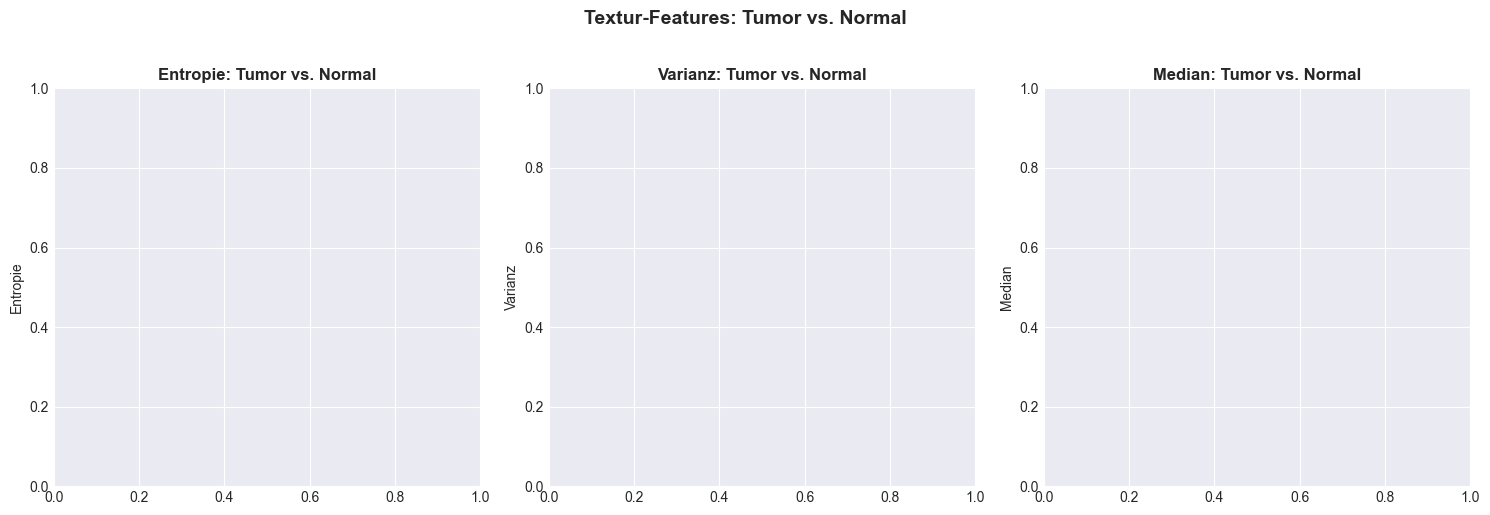

Plot gespeichert: results/figures/07_features_comparison_boxplot.png


In [17]:
# Boxplots für Vergleich
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Entropie
sns.boxplot(data=df_merged, x='label', y='entropy', ax=axes[0])
axes[0].set_title('Entropie: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Entropie')

# Varianz
sns.boxplot(data=df_merged, x='label', y='variance', ax=axes[1])
axes[1].set_title('Varianz: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianz')

# Median
sns.boxplot(data=df_merged, x='label', y='median', ax=axes[2])
axes[2].set_title('Median: Tumor vs. Normal', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Median')

plt.suptitle('Textur-Features: Tumor vs. Normal', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '07_features_comparison_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot gespeichert: results/figures/07_features_comparison_boxplot.png")

## 9. Bildbeispiele mit Feature-Werten

Zeigen wir konkrete Beispiele: Tumor vs. Normal mit ihren Entropie-Werten

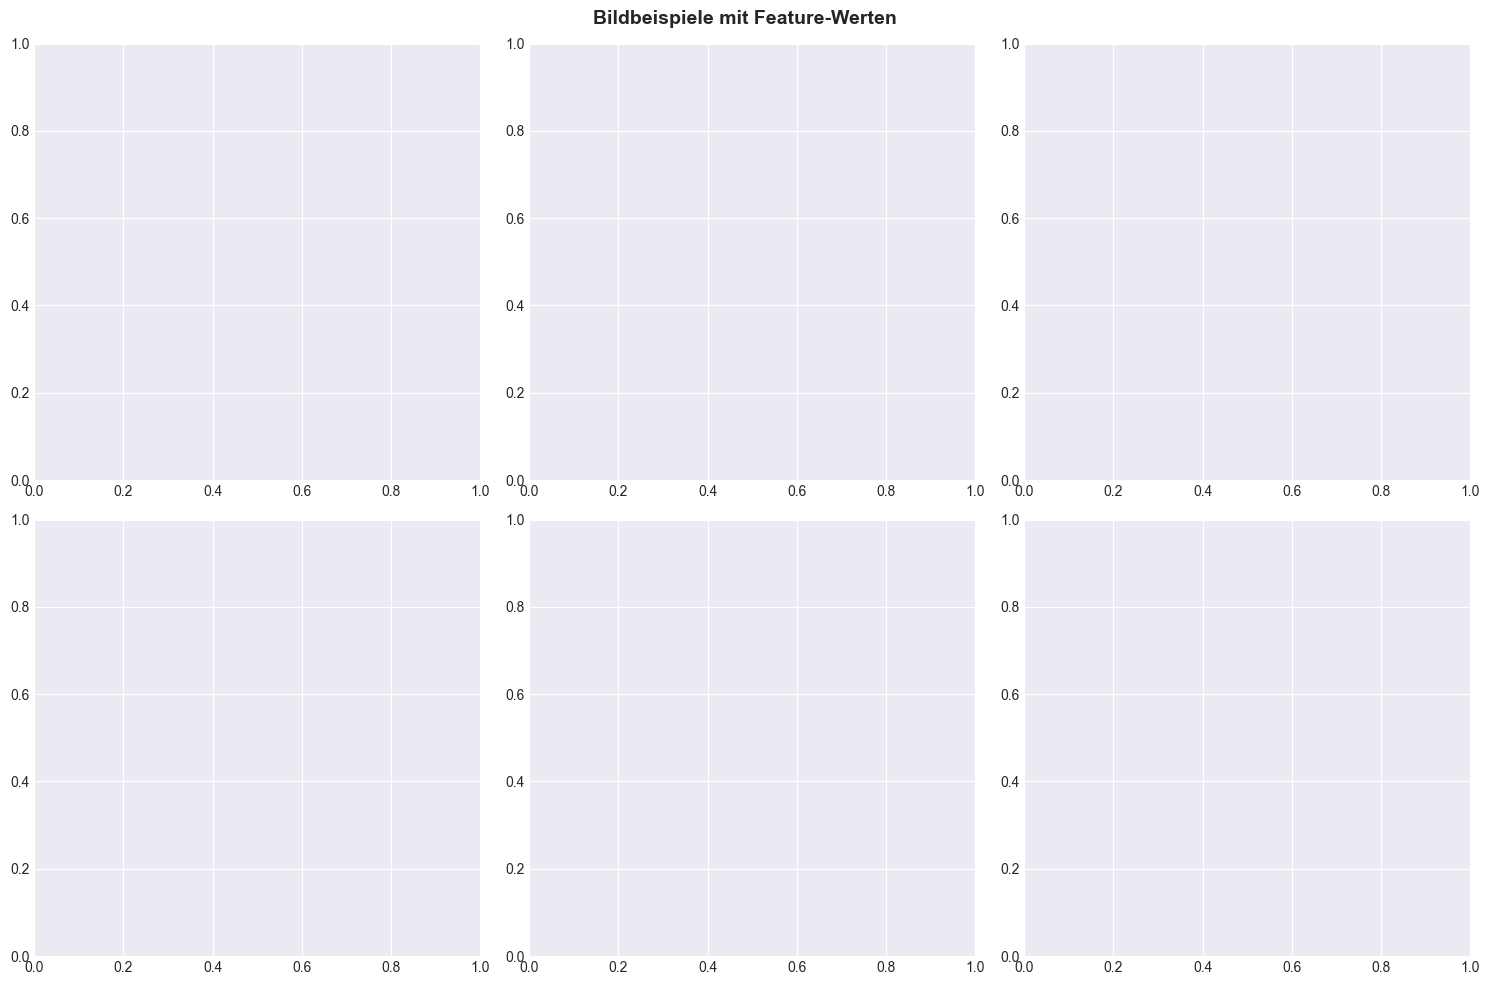

Plot gespeichert: results/figures/08_image_examples_with_features.png


In [18]:
# Je 3 Beispiele pro Klasse
tumor_samples = df_merged[df_merged['label'] == 'Tumor'].head(3)
normal_samples = df_merged[df_merged['label'] == 'Normal'].head(3)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Tumor-Beispiele
for i, (idx, row) in enumerate(tumor_samples.iterrows()):
    img_path = DATA_DIR / row['filename']
    img = io.imread(img_path)
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(
        f"Tumor\nEntropie: {row['entropy']:.3f}\nVarianz: {row['variance']:.4f}",
        fontsize=10,
        fontweight='bold',
        color='red'
    )
    axes[0, i].axis('off')

# Normal-Beispiele
for i, (idx, row) in enumerate(normal_samples.iterrows()):
    img_path = DATA_DIR / row['filename']
    img = io.imread(img_path)
    
    axes[1, i].imshow(img)
    axes[1, i].set_title(
        f"Normal\nEntropie: {row['entropy']:.3f}\nVarianz: {row['variance']:.4f}",
        fontsize=10,
        fontweight='bold',
        color='green'
    )
    axes[1, i].axis('off')

plt.suptitle('Bildbeispiele mit Feature-Werten', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '08_image_examples_with_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot gespeichert: results/figures/08_image_examples_with_features.png")

## 10. Scatter-Plots: Feature-Beziehungen

Wie hängen die Features zusammen? Gibt es Cluster?

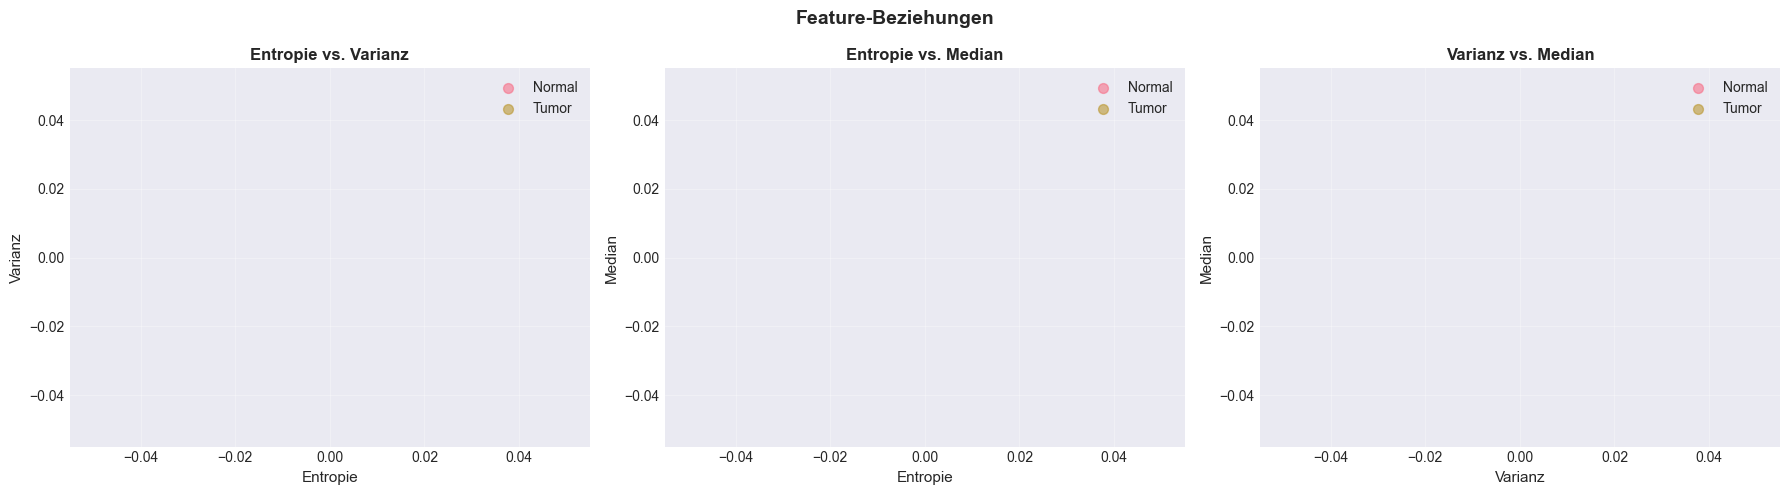

Plot gespeichert: results/figures/09_feature_relationships.png


In [19]:
# Scatter-Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Entropie vs. Varianz
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[0].scatter(data['entropy'], data['variance'], label=label, alpha=0.6, s=50)
axes[0].set_xlabel('Entropie', fontsize=11)
axes[0].set_ylabel('Varianz', fontsize=11)
axes[0].set_title('Entropie vs. Varianz', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Entropie vs. Median
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[1].scatter(data['entropy'], data['median'], label=label, alpha=0.6, s=50)
axes[1].set_xlabel('Entropie', fontsize=11)
axes[1].set_ylabel('Median', fontsize=11)
axes[1].set_title('Entropie vs. Median', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Varianz vs. Median
for label in ['Normal', 'Tumor']:
    data = df_merged[df_merged['label'] == label]
    axes[2].scatter(data['variance'], data['median'], label=label, alpha=0.6, s=50)
axes[2].set_xlabel('Varianz', fontsize=11)
axes[2].set_ylabel('Median', fontsize=11)
axes[2].set_title('Varianz vs. Median', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Feature-Beziehungen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '09_feature_relationships.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot gespeichert: results/figures/09_feature_relationships.png")

## 11. Zusammenfassung Teil 2

### Was wir erreicht haben:

1. Textur-Features für alle Bilder berechnet:
   - Entropie (Komplexität)
   - Varianz (Intensitätsschwankung)
   - Median (zentrale Tendenz)

2. Features mit Labels kombiniert

3. DataFrame gespeichert: `data/processed/features_with_labels.csv`

4. Erste Analyse durchgeführt:
   - Boxplots zeigen Unterschiede
   - Scatter-Plots zeigen Feature-Beziehungen

### Erkenntnisse:

**Überprüfe die Plots:**
- Sind Tumor-Werte höher/niedriger als Normal?
- Überlappen die Gruppen stark?
- Welches Feature trennt am besten?

### Nächster Schritt (Teil 3):

- Detaillierte statistische Analyse
- Histogramme (wie im Projektauftrag gefordert)
- Korrelations-Heatmap
- Finale Visualisierungen für Präsentation

---

**Status:** Teil 2 komplett

**Bereit für:** Teil 3 - Statistische Analyse & Visualisierung

---